<a href="https://colab.research.google.com/github/ammarhusain/colab-sandbox/blob/master/neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Example

Build a 2-hidden layers fully connected neural network (a.k.a multilayer perceptron) with TensorFlow v2.

This example is using a low-level approach to better understand all mechanics behind building neural networks and the training process.


## Neural Network Overview

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>

## MNIST Dataset Overview

This example is using MNIST handwritten digits. The dataset contains 60,000 examples for training and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 255. 

In this example, each image will be converted to float32, normalized to [0, 1] and flattened to a 1-D array of 784 features (28*28).

![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)

More info: http://yann.lecun.com/exdb/mnist/

In [0]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow.keras import Model, layers
import numpy as np
tf.enable_eager_execution()

In [0]:
# MNIST dataset parameters.
num_classes = 10 # total classes (0-9 digits).
num_features = 784 # data features (img shape: 28*28).

# Training parameters.
learning_rate = 0.1
training_steps = 2000
batch_size = 256
display_step = 100

# Network parameters.
n_hidden_1 = 128 # 1st layer number of neurons.
n_hidden_2 = 256 # 2nd layer number of neurons.

In [4]:
# Prepare MNIST data.
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Flatten images to 1-D vector of 784 features (28*28).
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

11501568/11490434 [==============================] - 0s 0us/step


In [0]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [0]:
# Create TF Model.
class NeuralNet(Model):
    # Set layers.
    def __init__(self):
        super(NeuralNet, self).__init__()
        # First fully-connected hidden layer.
        self.fc1 = layers.Dense(n_hidden_1, activation=tf.nn.relu)
        # First fully-connected hidden layer.
        self.fc2 = layers.Dense(n_hidden_2, activation=tf.nn.relu)
        # Second fully-connecter hidden layer.
        self.out = layers.Dense(num_classes, activation=tf.nn.softmax)

    # Set forward pass.
    def call(self, x, is_training=False):
        x = self.fc1(x)
        x = self.fc2(x)
        #?? What about fc2?
        x = self.out(x)
        if not is_training:
            # tf cross entropy expect logits without softmax, so only
            # apply softmax when not training.
            x = tf.nn.softmax(x)
        return x

# Build neural network model.
neural_net = NeuralNet()

In [0]:
# Cross-Entropy Loss.
# Note that this will apply 'softmax' to the logits.
def cross_entropy_loss(x, y):
    # Convert labels to int 64 for tf cross-entropy function.
    y = tf.cast(y, tf.int64)
    # Apply softmax to logits and compute cross-entropy.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x)
    # Average loss across the batch.
    return tf.reduce_mean(loss)

# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

# Stochastic gradient descent optimizer.
optimizer = tf.train.GradientDescentOptimizer(learning_rate)

In [0]:
# Optimization process. 
def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        # Forward pass.
        pred = neural_net(x, is_training=True)
        # Compute loss.
        loss = cross_entropy_loss(pred, y)
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = neural_net.trainable_variables
    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [30]:
# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = neural_net(batch_x, is_training=True)
        loss = cross_entropy_loss(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 100, loss: 2.121365, accuracy: 0.492188
step: 200, loss: 1.852397, accuracy: 0.671875
step: 300, loss: 1.823602, accuracy: 0.640625
step: 400, loss: 1.761584, accuracy: 0.730469
step: 500, loss: 1.720879, accuracy: 0.746094
step: 600, loss: 1.728588, accuracy: 0.742188
step: 700, loss: 1.663140, accuracy: 0.828125
step: 800, loss: 1.627132, accuracy: 0.863281
step: 900, loss: 1.622001, accuracy: 0.851562
step: 1000, loss: 1.588187, accuracy: 0.894531
step: 1100, loss: 1.569499, accuracy: 0.910156
step: 1200, loss: 1.530856, accuracy: 0.953125
step: 1300, loss: 1.568276, accuracy: 0.906250
step: 1400, loss: 1.556331, accuracy: 0.917969
step: 1500, loss: 1.559312, accuracy: 0.917969
step: 1600, loss: 1.564643, accuracy: 0.917969
step: 1700, loss: 1.562888, accuracy: 0.925781
step: 1800, loss: 1.563866, accuracy: 0.910156
step: 1900, loss: 1.518610, accuracy: 0.964844
step: 2000, loss: 1.555947, accuracy: 0.917969


In [32]:
# Test model on validation set.
pred = neural_net(x_test, is_training=False)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.925300


In [0]:
# Visualize predictions.
import matplotlib.pyplot as plt

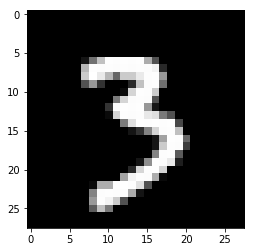

Model prediction: 3


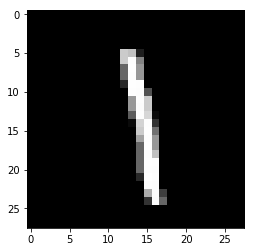

Model prediction: 1


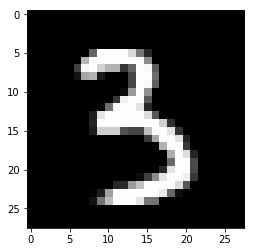

Model prediction: 3


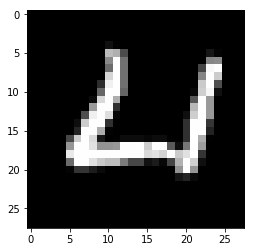

Model prediction: 6


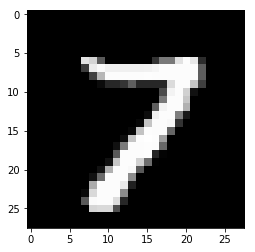

Model prediction: 7


In [34]:
# Predict 5 images from validation set.
n_images = 5
test_images = x_test[30:40+n_images]
predictions = neural_net(test_images)

# Display image and model prediction.
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction: %i" % np.argmax(predictions.numpy()[i]))